# Project - Ensemble

In this exercise, we will focus on underage drinking. The data set contains data about high school students. Each row represents a single student. The columns include the characteristics of deidentified students. This is a binary classification task: predict whether a student drinks alcohol or not (this is the **alc** column: 1=Yes, 0=No). This is an important prediction task to detect underage drinking and deploy intervention techniques. 

## Description of Variables

The description of variables are provided in "Alcohol - Data Dictionary.docx"

## Goal

Use the **alcohol.csv** data set and build a model to predict **alc**. 

# Read and Prepare the Data

In [1]:
# Common imports

import pandas as pd
import numpy as np

np.random.seed(42)

# Get the data

In [2]:
#We will predict the "price" value in the data set:

alcohol = pd.read_csv("alcohol.csv")
alcohol.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,gender,alc
0,18,2,1,4,2,0,5,4,2,5,2,M,1
1,18,4,3,1,0,0,4,4,2,3,9,M,1
2,15,4,3,2,3,0,5,3,4,5,0,F,0
3,15,3,3,1,4,0,4,3,3,3,10,F,0
4,17,3,2,1,2,0,5,3,5,5,2,M,1


# Split data (train/test)

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(alcohol, test_size=0.3)

# Data Prep

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

## Separate the target variable 

In [5]:
train_target = train['alc']
test_target = test['alc']

train_inputs = train.drop(['alc'], axis=1)
test_inputs = test.drop(['alc'], axis=1)

## Feature Engineering: Derive a new column

Examples:
- Ratio of study time to travel time
- Student is younger than 18 or not
- Average of father's and mother's level of education
- (etc.)

In [6]:
train_inputs['traveltime'].describe()

count    23800.000000
mean         1.172521
std          0.856668
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: traveltime, dtype: float64

<AxesSubplot:>

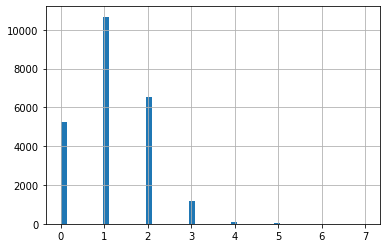

In [7]:
train_inputs['traveltime'].hist(bins=50)

In [15]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['traveltime_binned'] = pd.cut(df1['traveltime'],
                                       bins=[-0.5,0.5,1,8],  #bins=[exclusive, inclusive]
                                       labels=False, 
                                       include_lowest=True,
                                       ordered=True)
 
    # Use the formula, though fill in 0s when the value is 0/0 (because 0/0 generates "nan" values)
    df1['age_greater_than_16'] = np.where(df1['age'] > 16, 1, 0)


    
#     One can also do this if the categorical values are of interest:    
#     df1['num_reviews_binned'] = pd.cut(df1['number_of_reviews'],
#                                        bins=[0,0.5,1,5,15,50,10000], 
#                                        labels=['None','Very few','Few','Medium','Many','Too many'], 
#                                        include_lowest=True,
#                                        ordered=False)

    #
    return df1[['traveltime_binned','age_greater_than_16']]

    # Using this to check whether the calculation is made correctly:
    #return df1

In [16]:
#Let's test the new function:

# Send train set to the function we created
new_col(train)

,traveltime_binned,age_greater_than_16
12759,1,1
4374,2,1
8561,1,1
10697,1,1
19424,1,0
...,...,...
16850,1,0
6265,1,1
11284,2,1
860,2,1


array([[<AxesSubplot:title={'center':'traveltime_binned'}>,
        <AxesSubplot:title={'center':'age_greater_than_16'}>]],
      dtype=object)

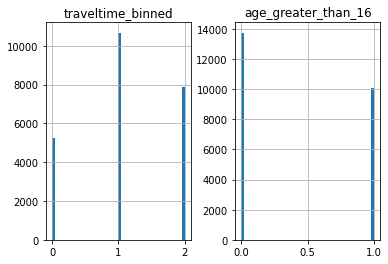

In [17]:
#Check the new distribution

new_col(train).hist(bins=50)

##  Identify the numeric, binary, and categorical columns

In [18]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [19]:
numeric_columns

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'health',
 'absences']

In [20]:
categorical_columns

['gender']

In [21]:
feat_eng_columns = ['traveltime', 'age']

In [22]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['failures']

In [23]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

# Pipeline

In [24]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [25]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [26]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [27]:
# Create a pipeline for the transformed column here
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])



In [28]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
         ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [29]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[ 0.66643886,  0.96597412,  0.90362635, ...,  0.        ,
        -0.14819955,  1.16887792],
       [ 0.66643886, -0.93881619, -1.68666277, ...,  0.        ,
         1.21310856,  1.16887792],
       [ 0.66643886,  0.33104402,  0.04019664, ...,  0.        ,
        -0.14819955,  1.16887792],
       ...,
       [ 0.66643886, -2.20867639, -2.55009248, ...,  0.        ,
         1.21310856,  1.16887792],
       [ 1.6195814 , -0.30388608, -1.68666277, ...,  0.        ,
         1.21310856,  1.16887792],
       [ 1.6195814 , -0.30388608, -2.55009248, ...,  0.        ,
        -0.14819955,  1.16887792]])

In [30]:
train_x.shape

(23800, 15)

# Tranform: transform() for TEST

In [31]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[-1.23984621,  0.33104402,  1.76705606, ...,  0.        ,
        -0.14819955, -0.85552133],
       [-1.23984621, -0.30388608,  0.04019664, ...,  0.        ,
         1.21310856, -0.85552133],
       [-0.28670367,  0.33104402,  0.04019664, ...,  0.        ,
        -0.14819955, -0.85552133],
       ...,
       [ 0.66643886, -0.30388608,  0.04019664, ...,  0.        ,
         1.21310856,  1.16887792],
       [-1.23984621, -0.93881619,  0.04019664, ...,  0.        ,
         1.21310856, -0.85552133],
       [-1.23984621,  0.96597412,  0.04019664, ...,  0.        ,
        -1.50950766, -0.85552133]])

In [32]:
test_x.shape

(10200, 15)

# Calculate the Baseline

In [34]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_target)

DummyClassifier(strategy='most_frequent')

In [35]:
from sklearn.metrics import accuracy_score

In [37]:
#Baseline Train Accuracy
dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_target, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.5234873949579832


In [39]:
#Baseline Test Accuracy
dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_target, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.5194117647058824


# Train a voting classifier 

In [40]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import SGDClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier


dtree_clf = DecisionTreeClassifier(max_depth=20)
log_clf = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', C=10, max_iter=1000)
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3)

voting_clf = VotingClassifier(
            estimators=[('dt', dtree_clf), 
                        ('lr', log_clf), 
                        ('sgd', sgd_clf)],
            voting='hard')

voting_clf.fit(train_x, train_target)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=20)),
                             ('lr',
                              LogisticRegression(C=10, max_iter=1000,
                                                 multi_class='multinomial')),
                             ('sgd', SGDClassifier(max_iter=10000))])

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
#Train accuracy

train_y_pred = voting_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.8325210084033613


In [43]:
#Test accuracy

test_y_pred = voting_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.8205882352941176


In [45]:
from sklearn.metrics import confusion_matrix

In [47]:
confusion_matrix(test_target, test_y_pred)

array([[4459,  839],
       [ 991, 3911]], dtype=int64)

# Train a bagging classifier

In [54]:
from sklearn.ensemble import BaggingClassifier 


#If do pasting is of interest, change "bootstrap=False"
#n_jobs=-1 means use all CPU cores
#bagging automatically performs soft voting

bag_clf = BaggingClassifier( 
            SGDClassifier(), n_estimators=50, 
            max_samples=1000, bootstrap=True, n_jobs=-1) 

bag_clf.fit(train_x, train_target)



BaggingClassifier(base_estimator=SGDClassifier(), max_samples=1000,
                  n_estimators=50, n_jobs=-1)

In [56]:
#Train accuracy

train_y_pred = bag_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.822436974789916


In [57]:
#Test accuracy

test_y_pred = bag_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.8206862745098039


# Train a random forest classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier 

rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=10, n_jobs=-1) 

rnd_clf.fit(train_x, train_target)

RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)

In [60]:
#Train accuracy

train_y_pred = rnd_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.8438235294117648


In [61]:
#Test accuracy

test_y_pred = rnd_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.812843137254902


In [62]:
rnd_clf.feature_importances_

array([0.09907459, 0.24812948, 0.0804817 , 0.06782822, 0.16960903,
       0.04787275, 0.02329884, 0.01832449, 0.02853441, 0.03284474,
       0.02656595, 0.02536708, 0.00253537, 0.05996707, 0.06956628])

In [63]:
# Round to two decimals
np.round(rnd_clf.feature_importances_,2)

array([0.1 , 0.25, 0.08, 0.07, 0.17, 0.05, 0.02, 0.02, 0.03, 0.03, 0.03,
       0.03, 0.  , 0.06, 0.07])

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,gender,alc
12759,17,5,4,1,1,0,5,3,2,5,8,F,1
4374,17,2,1,2,3,0,5,3,4,5,23,M,0
8561,17,4,3,1,1,0,5,4,4,5,1,M,1
10697,17,4,4,1,2,0,4,4,4,3,3,M,0
19424,15,6,4,1,4,0,4,2,2,1,0,F,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,15,1,2,1,1,0,4,4,0,3,0,M,1
6265,17,2,2,1,2,0,4,3,5,4,11,M,1
11284,17,0,0,2,3,0,4,3,3,3,12,F,1
860,18,3,1,2,3,0,4,4,4,6,16,M,1


# Train an adaboost classifier

In [65]:
from sklearn.ensemble import AdaBoostClassifier 


ada_clf = AdaBoostClassifier( 
            DecisionTreeClassifier(max_depth=5), n_estimators=500, 
            learning_rate=0.1) 


ada_clf.fit(train_x, train_target)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=500)

In [66]:
#Train accuracy

train_y_pred = ada_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.8821008403361345


In [67]:
#Test accuracy

test_y_pred = ada_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.8186274509803921


# Train a gradient boosting classifier

In [68]:
#Use GradientBoosting

from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(max_depth=2, n_estimators=100, learning_rate=0.1) 

gbclf.fit(train_x, train_target)

GradientBoostingClassifier(max_depth=2)

In [70]:
#Train accuracy

train_y_pred = gbclf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.8190336134453782


In [71]:
#Test accuracy

test_y_pred = gbclf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.8116666666666666
